<a href="https://colab.research.google.com/github/techisteps/KaggleCompetition/blob/main/Kaggle_Housing_Prices_20240526.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

In [1]:
# Upload Kaggle token file
from google.colab import files
files.upload_file(filename = "kaggle.json")

# Setup Kaggle environment
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/ && chmod 600 /root/.kaggle/kaggle.json
!rm /content/kaggle.json


# Download and extract project data
!kaggle competitions download -c home-data-for-ml-course
!unzip /content/home-data-for-ml-course.zip

Saved kaggle.json to /content/kaggle.json
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 78.0MB/s]
Archive:  /content/home-data-for-ml-course.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: sample_submission.csv.gz  
  inflating: test.csv                
  inflating: test.csv.gz             
  inflating: train.csv               
  inflating: train.csv.gz            


# Analysis
You can now start your analysis

In [117]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, normalize

file_train = "/content/train.csv"
file_test = "/content/test.csv"
file_sample_submission = "/content/sample_submission.csv"
file_data_disc = "/content/data_description.txt"

# train_filedata = pd.read_csv(file_train, index_col="Id")
# test_filedata = pd.read_csv(file_test, index_col="Id")
train_filedata = pd.read_csv(file_train)
test_data = pd.read_csv(file_test)

train_data = train_filedata.copy()
target_y = train_data['SalePrice']
# train_data.drop('SalePrice', axis=1, inplace=True)

# test_data = test_filedata.copy()

# train_data.drop('SalePrice', axis=1, inplace=True)
# train_data = train_data.drop('SalePrice', axis=1)

features = train_data.columns.to_list()

features_obj = train_data.select_dtypes(include = ['O', 'object']).columns
features_num = train_data.select_dtypes(include = ['float64', 'int64']).columns

# EDA and Feature Engineering

# All non-numeric columns
```python
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
```

In [ ]:
# !pip install ydata-profiling

from ydata_profiling import ProfileReport
# tmp = train_data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities','LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']]
tmp = train_data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']]

profile = ProfileReport(tmp, title="Profiling Report for all non-numeric columns")
# # profile.to_widgets()
# profile.to_notebook_iframe()
profile.to_file("your_report_non_numeric.html")

In [70]:
features_obj.to_list()

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [118]:
def obj_OHE(df, colnames):
  clf_objOHE = OneHotEncoder()
  tmp_objcolumns_OHE = clf_objOHE.fit_transform(df[colnames])
  tmp_objcolumns_OHE_df = pd.DataFrame(tmp_objcolumns_OHE.toarray(), columns=clf_objOHE.get_feature_names_out())
  # tmp_objcolumns_OHE_df.head()
  # tmp_objcolumns_OHE_df.info()
  return tmp_objcolumns_OHE_df

In [119]:
all_train_obj_OHE = obj_OHE(train_data, features_obj.to_list())
tmp_train_data = train_data.copy()
tmp_train_data.drop(columns=features_obj.to_list(), inplace=True)
train_data_OHE = pd.concat([tmp_train_data, all_train_obj_OHE], axis=1)


all_test_obj_OHE = obj_OHE(test_data, features_obj.to_list())
tmp_test_data = test_data.copy()
tmp_test_data.drop(columns=features_obj.to_list(), inplace=True)
test_data_OHE = pd.concat([tmp_test_data, all_test_obj_OHE], axis=1)


del tmp_train_data
del tmp_test_data

In [ ]:
# display.max_columns = 200
# from google.colab.data_table import DataTable
# DataTable.max_columns = 100
# DataTable.num_rows_per_page = 300

# all_train_obj_OHE.isna().sum()
# all_train_obj_OHE[all_train_obj_OHE.isna().any(axis=1)]
# all_train_obj_OHE.isna()
# all_test_obj_OHE

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial


> MSZoning column looks promising as demand for low density location might be high and demand for high density might be less, thus low density area might be generally expensive.

- Candidate for One-hot-encoding

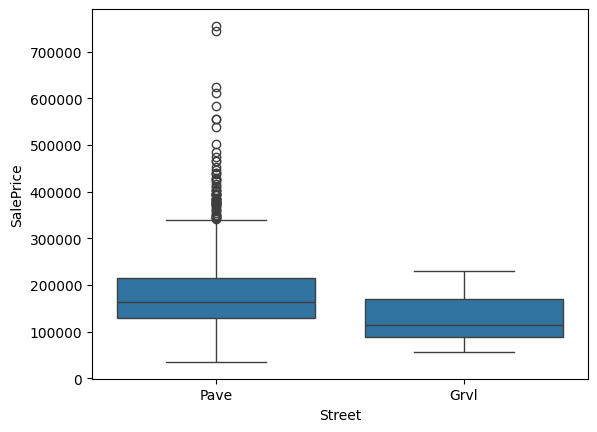

In [35]:
# @title Default title text
ColName = "Street" # @param {type:"string"}

import seaborn as sns
tmpTF1 = train_filedata[[ColName,'SalePrice']]
# sns.countplot(x=tmp);
sns.boxplot(x= ColName, y="SalePrice", data=tmpTF1);

# TODO
Convert catagoric columns to OHE and check corelation with price.

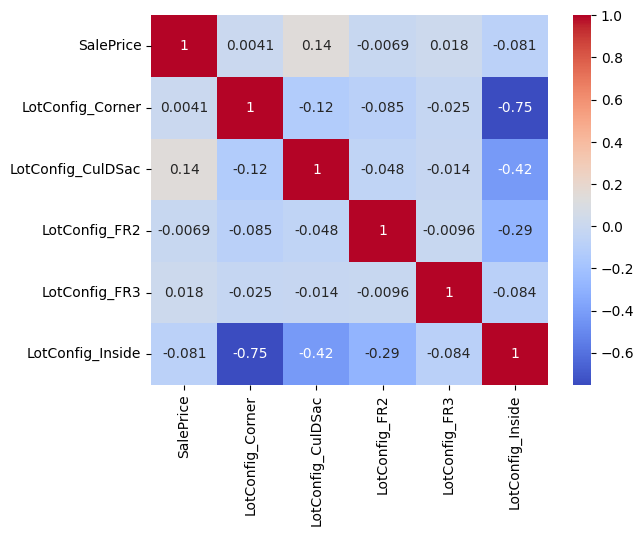

In [36]:
# @title Default title text
CategoryName = "LotConfig" # @param {type:"string"}
import seaborn as sns
# tmpOHE = OneHotEncoder(sparse=False).fit_transform(train_data[['MSZoning']])
tmpOHE = OneHotEncoder(sparse_output=False)
# PavedDriveOHE = tmpOHE.fit_transform(train_data[['PavedDrive']])
CategoryNameOHE = tmpOHE.fit_transform(train_data[[CategoryName]])
tmpOHE.get_feature_names_out()
CategoryNameOHE = pd.DataFrame(CategoryNameOHE, columns=tmpOHE.get_feature_names_out())
CategoryNameOHE.head()

tmpTF2 = train_filedata['SalePrice'].copy()
tmpTF2 = pd.concat([tmpTF2, CategoryNameOHE], axis=1)
sns.heatmap(tmpTF2.corr(), annot=True, cmap='coolwarm');

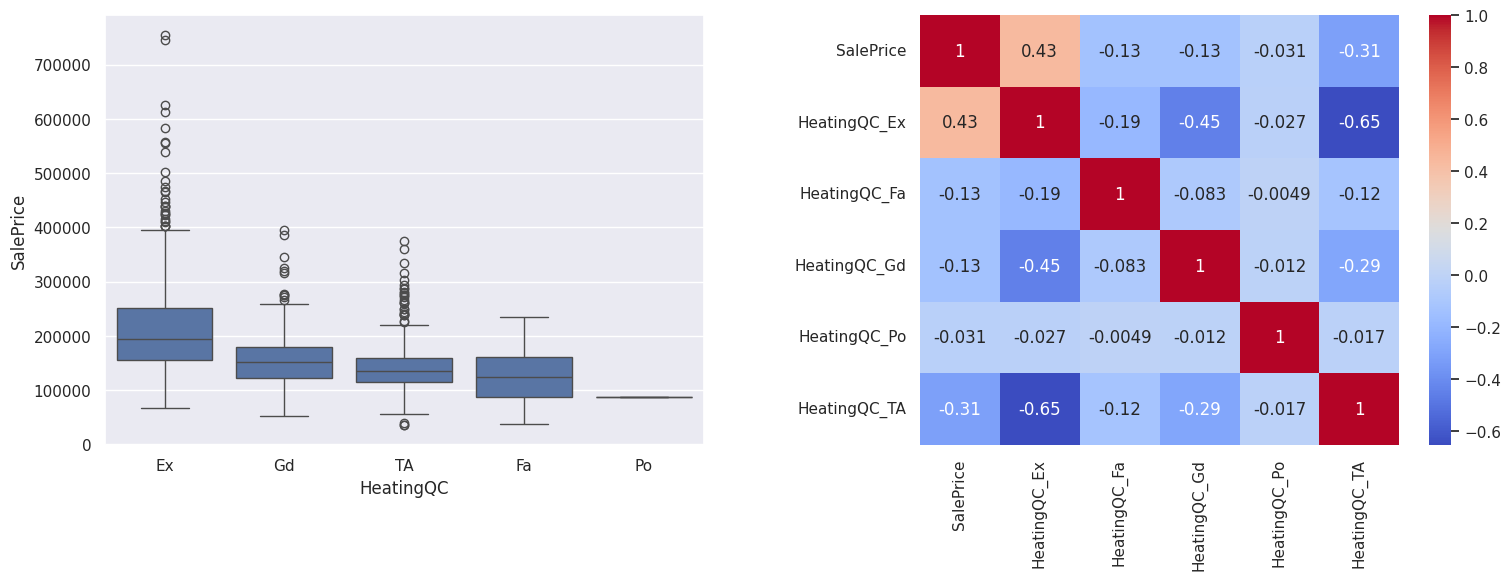

In [66]:
# @title Default title text
ColName = "HeatingQC" # @param {type:"string"}
import matplotlib.pyplot as plt

import seaborn as sns
tmpTF1 = train_filedata[[ColName,'SalePrice']]
# sns.countplot(x=tmp);
# sns.boxplot(x= ColName, y="SalePrice", data=tmpTF1);


# tmpOHE = OneHotEncoder(sparse=False).fit_transform(train_data[['MSZoning']])
tmpOHE = OneHotEncoder(sparse_output=False)
# PavedDriveOHE = tmpOHE.fit_transform(train_data[['PavedDrive']])
CategoryNameOHE = tmpOHE.fit_transform(train_data[[ColName]])
tmpOHE.get_feature_names_out()
CategoryNameOHE = pd.DataFrame(CategoryNameOHE, columns=tmpOHE.get_feature_names_out())
CategoryNameOHE.head()

tmpTF2 = train_filedata['SalePrice'].copy()
tmpTF2 = pd.concat([tmpTF2, CategoryNameOHE], axis=1)
# sns.heatmap(tmpTF2.corr(), annot=True, cmap='coolwarm');


sns.set()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout(w_pad=10)
sns.boxplot(x= ColName, y="SalePrice", data=tmpTF1, ax=ax[0]);
sns.heatmap(tmpTF2.corr(), annot=True, cmap='coolwarm', ax=ax[1]);
plt.show()

# All numeric columns
```python
Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')
```

In [ ]:
# !pip install ydata-profiling

from ydata_profiling import ProfileReport
tmp = train_data[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice']]

profile = ProfileReport(tmp, title="Profiling Report for all numeric columns")
# # profile.to_widgets()
# profile.to_notebook_iframe()
profile.to_file("your_report_numeric.html")

/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
!zip -r /content/your_report_numeric.html.zip /content/your_report_numeric.html

  adding: content/your_report_numeric.html (deflated 88%)


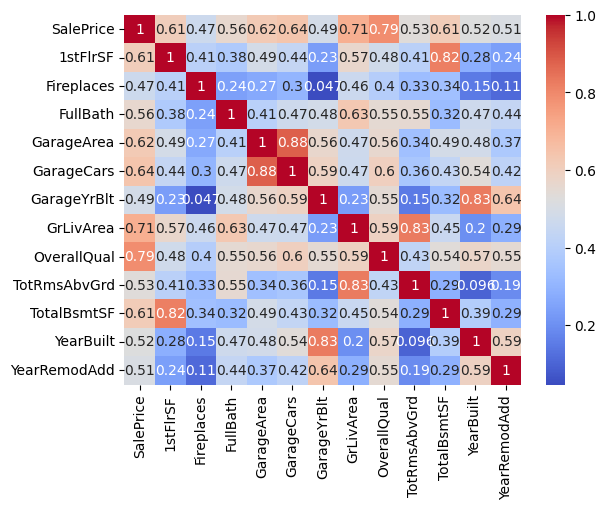

In [ ]:
# tmp = train_filedata[['LotFrontage','SalePrice','LotArea']]
# sns.scatterplot(x="LotFrontage", y="SalePrice", size='LotArea', data=tmp);

tmp = train_filedata[['SalePrice','1stFlrSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']]
sns.heatmap(tmp.corr(), annot=True, cmap='coolwarm');

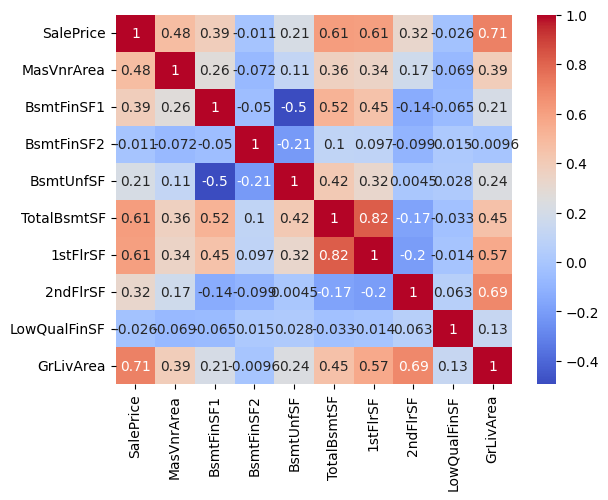

In [ ]:
import seaborn as sns
# tmp = train_data[['SalePrice', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']]
tmp = train_filedata[['SalePrice','MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']]
# sns.scatterplot(x="SalePrice", y=col, data=train_data[[col, 'SalePrice']]);
sns.heatmap(tmp.corr(), annot=True, cmap='coolwarm');
??sns.heatmap

# TODO
Implement feature selection using
- Variance threshold
- K-best features (Filter Method)
- RFE
- Boruta

https://www.youtube.com/watch?v=hCwTDTdYirg&t=3s

In [ ]:
# display.max_columns = 100
# t = features_num
# 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
# 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea'

# Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',   'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
# 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
#        'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'], dtype='object')
# train_data[['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual','SalePrice']].corr()
# target_y.corr(train_data['LotArea'])
train_data = train_data.drop(columns= ['MoSold', 'YrSold','3SsnPorch'], axis=1)

In [ ]:
sns.scatterplot(x="SalePrice", y="ALLBATHwLot", data=tmp);

In [ ]:

import seaborn as sns
nor = Normalizer()
# nor.fit(train_data)
# tmp = train_data['SalePrice']
train_data['ALLBATH'] = train_data['BsmtFullBath'] + train_data['BsmtHalfBath'] + train_data['FullBath'] + train_data['HalfBath']
train_data['ALLBATHwLot'] = train_data['LotArea'] / (train_data['BsmtFullBath'] + train_data['BsmtHalfBath'] + train_data['FullBath'] + train_data['HalfBath'])
train_data['ALLFULLBATH'] = train_data['BsmtFullBath'] + train_data['FullBath']
train_data['ALLHALFBATH'] = train_data['BsmtHalfBath'] + train_data['HalfBath']
# tmp = train_data[['SalePrice', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']]
tmp = train_data[['SalePrice', 'ALLBATH', 'ALLFULLBATH', 'ALLHALFBATH','ALLBATHwLot']]
# tmp = pd.DataFrame(nor.transform(tmp), columns = tmp.columns)
tmp.describe()
# sns.pairplot(tmp, hue="BsmtFullBath")
sns.scatterplot(x="SalePrice", y="ALLBATHwLot", data=tmp);
# sns.scatterplot(x="SalePrice", y="1stFlrSF", hue="LotArea", size="LotFrontage", data=tmp);
# ??sns.scatterplot
# tmp = train_data[['SalePrice', 'BsmtUnfSF', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt']]
# sns.pairplot(tmp, hue="LotArea")
# ??sns.pairplot
# sns.boxplot(x="Alley", y="SalePrice", hue="LotFrontage", palette='YlGnBu', data=train_data);

In [ ]:
import seaborn as sns
def plotCorr(col):
  print(train_data['SalePrice'].corr(train_data[col]))
  sns.scatterplot(x="SalePrice", y=col, data=train_data[[col, 'SalePrice']]);

plotCorr("OpenPorchSF")

In [ ]:
# Analysis
# train_data['SFT'] = train_data['1stFlrSF'] + train_data['2ndFlrSF'] + train_data['LowQualFinSF'] + train_data['GrLivArea']
# tmp = train_data[['SalePrice', 'SFT']]
# tmp.describe()
# sns.scatterplot(x="SalePrice", y="SFT", data=tmp);

# Action
train_data['SFT'] = train_data['1stFlrSF'] + train_data['2ndFlrSF'] + train_data['LowQualFinSF'] + train_data['GrLivArea']
train_data.drop(columns=['SalePrice','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea'], axis=1, inplace=True)

test_data['SFT'] = test_data['1stFlrSF'] + test_data['2ndFlrSF'] + test_data['LowQualFinSF'] + test_data['GrLivArea']
test_data.drop(columns=['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea'], axis=1, inplace=True)

# train_data.drop('SFT', axis=1, inplace=True)
# test_data.drop('SFT', axis=1, inplace=True)

In [ ]:
# train_data_imp.select_dtypes(include = ['O']).columns
# train_data_imp.MSZoning.unique()

# !pip install ydata-profiling

from ydata_profiling import ProfileReport
# tmp = train_data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities','LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2']]
tmp = train_data[['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition']]

profile = ProfileReport(tmp, title="Profiling Report")
# # profile.to_widgets()
# profile.to_notebook_iframe()
profile.to_file("your_report.html")


/usr/local/lib/python3.10/dist-packages/ydata_profiling/profile_report.py:363: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train_data[features_obj]
# train_data.MSSubClass.unique()

train_data["MSSubClassTMP"] = train_data.MSSubClass.apply(lambda x: str(x))
train_data.drop(columns=["MSSubClass"], inplace=True)
train_data.rename(columns={"MSSubClassTMP": "MSSubClass"}, inplace=True)
train_data[["MSSubClass"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MSSubClass  1460 non-null   object
dtypes: object(1)
memory usage: 22.8+ KB


In [ ]:
train_data.OverallQual.unique()

train_data["OverallQualTMP"] = train_data.OverallQual.apply(lambda x: str(x))
train_data.drop(columns=["OverallQual"], inplace=True)
train_data.rename(columns={"OverallQualTMP": "OverallQual"}, inplace=True)
train_data[["OverallQual"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OverallQual  1460 non-null   object
dtypes: object(1)
memory usage: 22.8+ KB


In [ ]:
train_data.OverallCond.unique()

train_data["OverallCondTMP"] = train_data.OverallCond.apply(lambda x: str(x))
train_data.drop(columns=["OverallCond"], inplace=True)
train_data.rename(columns={"OverallCondTMP": "OverallCond"}, inplace=True)
train_data[["OverallCond"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OverallCond  1460 non-null   object
dtypes: object(1)
memory usage: 22.8+ KB


# Imputer null values from numeric columns
---

In [115]:
if 'tmp_train_data' in locals():
  del tmp_train_data
if 'tmp_test_data' in locals():
  del tmp_test_data

train_data['Id'] = 1
# test_data['Id'] = 1

tmp_train_data = train_data[['1stFlrSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']]
tmp_test_data = test_data[['1stFlrSF', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'OverallQual', 'TotRmsAbvGrd', 'TotalBsmtSF', 'YearBuilt', 'YearRemodAdd']]

train_data = pd.concat([tmp_train_data, train_data_OHE], axis=1)
test_data = pd.concat([tmp_test_data, test_data_OHE], axis=1)

In [116]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 317 entries, 1stFlrSF to SaleCondition_Partial
dtypes: float64(271), int64(46)
memory usage: 3.5 MB


In [120]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer

features = train_data.columns.to_list()

features_obj = train_data.select_dtypes(include = ['O', 'object']).columns
features_num = train_data.select_dtypes(include = ['float64', 'int64']).columns


numeric_transformation = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        # ("normalizer", Normalizer()),

    ]
)

object_transformation = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="xxx")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("nums", numeric_transformation , features_num),
        ("objs", object_transformation, features_obj),
    ]
)


preprocessor.fit(train_data)

train_data_imp = pd.DataFrame( preprocessor.transform(train_data), columns = preprocessor.get_feature_names_out())
test_data_imp = pd.DataFrame( preprocessor.transform(test_data), columns = preprocessor.get_feature_names_out())

print("Type of train_data_imp is: ", type(train_data_imp))
train_data_imp.info()

train_data_imp.rename(columns={"nums__Id": "Id"}, inplace=True)
test_data_imp.rename(columns={"nums__Id": "Id"}, inplace=True)


KeyError: "['SalePrice'] not in index"

In [ ]:
test_data_imp["Id"] = test_data_imp["Id"] + 1
test_data_imp = test_data_imp.astype({"Id": "int32"})
test_data_imp.head()
test_data_imp.dtypes

Id                               int32
nums__MSSubClass               float64
nums__LotFrontage              float64
nums__LotArea                  float64
nums__OverallQual              float64
                                ...   
objs__SaleCondition_AdjLand    float64
objs__SaleCondition_Alloca     float64
objs__SaleCondition_Family     float64
objs__SaleCondition_Normal     float64
objs__SaleCondition_Partial    float64
Length: 304, dtype: object

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(train_data_imp)


train_data_imp_pca = pca.transform(train_data_imp)
pca.explained_variance_ratio_

array([0.16041045, 0.07331221, 0.06318314, 0.04330732, 0.0294759 ,
       0.02667992, 0.02505619, 0.02360354, 0.02249575, 0.02203017,
       0.02113407, 0.02111137, 0.02044228, 0.01997282, 0.01856558,
       0.01802254, 0.01790649, 0.01708545, 0.01659414, 0.01495456,
       0.01452867, 0.01296256, 0.01250145, 0.01236742, 0.00967874,
       0.00910014, 0.00882653, 0.00834325, 0.0072749 , 0.00662645,
       0.00644842, 0.00610272, 0.00592179, 0.00569398, 0.00552854,
       0.00542734, 0.00519586, 0.00497067, 0.00464294, 0.00452989,
       0.00437232, 0.00430605, 0.00414011, 0.00401879, 0.00385741,
       0.00378295, 0.00362539, 0.00354611, 0.00349377, 0.00334932])

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import StackingRegressor

train_X, val_X, train_y, val_y = train_test_split(train_data_imp, target_y, random_state=1)
xgbr_model = XGBRegressor(random_state=1, gamma= 0.01, learning_rate= 0.1, max_depth= 5, n_estimator= 100)
hgbr_model = HistGradientBoostingRegressor(learning_rate= 0.1, loss= 'absolute_error', max_depth= 5, max_iter= 300, random_state=1)
rf_model = RandomForestRegressor(criterion= 'poisson', max_depth= 7, n_estimators= 300, random_state=1)
# lin_model = StackingRegressor()

modelVar = hgbr_model

search_space = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [2, 5, 7],
    # "gamma": [0.01, 0.1],
    "learning_rate": [0.001, 0.01, 0.1, 1]
}

hgbr_search_space = {
    "loss": ["squared_error", "absolute_error"],
    "learning_rate": [0.001, 0.01, 0.1, 1],
    "max_iter": [100, 200, 300],
    "max_depth": [2, 5, 7],
}

rf_search_space = {
    "n_estimators": [100, 200, 300],
    "criterion": ["squared_error", "friedman_mse", "poisson"],
    "max_depth": [2, 5, 7],
    # "gamma": [0.01, 0.1],
    # "learning_rate": [0.001, 0.01, 0.1, 1]
}

# GS = GridSearchCV(estimator= hgbr_model, param_grid= hgbr_search_space, cv=5, scoring=["neg_mean_absolute_error","r2"], refit="neg_mean_absolute_error", verbose=4)
# GS.fit(train_X, train_y)
# GS.best_params_

modelVar.fit(train_X, train_y)
modelVar.score(val_X, val_y)

0.863172023701613

In [ ]:
# GS.best_params_
# GS.best_score_
# GS.best_estimator_
# pd.DataFrame(GS.cv_results_).sort_values(by="rank_test_neg_mean_absolute_error")[['mean_test_neg_mean_absolute_error','std_test_neg_mean_absolute_error']]

# pd.DataFrame(GS.cv_results_).columns
# ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
#        'param_criterion', 'param_max_depth', 'param_n_estimators', 'params',
#        'split0_test_neg_mean_absolute_error',
#        'split1_test_neg_mean_absolute_error',
#        'split2_test_neg_mean_absolute_error',
#        'split3_test_neg_mean_absolute_error',
#        'split4_test_neg_mean_absolute_error',
#        'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
#        'rank_test_neg_mean_absolute_error', 'split0_test_r2', 'split1_test_r2',
#        'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2',
#        'std_test_r2', 'rank_test_r2']

rf_val_predictions = modelVar.predict(val_X)
rf_val_mae = mean_absolute_error(val_y, rf_val_predictions)
rf_val_mae


18335.281468414407

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor

train_X, val_X, train_y, val_y = train_test_split(train_data_imp, target_y, random_state=1)
# rf_model = HistGradientBoostingRegressor(random_state=1)
rf_model = XGBRegressor(random_state=1)
# rf_model = RandomForestRegressor(n_estimators=100, random_state=1)
rf_model.fit(train_X, train_y)
rf_model

rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(val_y, rf_val_predictions)
rf_val_mae

# rf_model.score(val_X, val_y)


16613.24428510274

In [ ]:
test_validation =  hgbr_model.predict(test_data_imp)

In [ ]:
submission = pd.DataFrame({'Id': test_data_imp.Id, 'SalePrice': test_validation})
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit home-data-for-ml-course -f submission.csv -m "Another submission through the Google Colab!"

100% 36.5k/36.5k [00:00<00:00, 97.8kB/s]
Successfully submitted to Housing Prices Competition for Kaggle Learn Users